# **Elaboration d'un modèle via CNN Transfer Learning**

## **Import et installation des packages**

In [8]:
!pip install tensorflow numpy matplotlib scikit-learn

In [9]:
import os
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, InceptionResNetV2
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D

## **Téléchargement des données**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Chemin vers le dossier contenant toutes les images
images_folder = '/content/drive/MyDrive/transformed_images'

# Chemins vers les dossiers de sortie
train_dir = '/content/drive/MyDrive/train'
val_dir = '/content/drive/MyDrive/validation'
test_dir = '/content/drive/MyDrive/test'

# Création des dossiers de sortie s'ils n'existent pas
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

## **Selection des races pour l'entrainemen**

In [13]:
selected_classes3 = ['n02085782-Japanese_spaniel', 'n02091032-Italian_greyhound', 'n02100735-English_setter']

## **Séparation des données pour l'entrainement, la validation et le test**

In [14]:
def split_data(class_name, files, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    print(f"Splitting data for class: {class_name}")
    print(f"Total files: {len(files)}")
    np.random.shuffle(files)
    train_split = int(train_ratio * len(files))
    val_split = int((train_ratio + val_ratio) * len(files))

    train_files = files[:train_split]
    val_files = files[train_split:val_split]
    test_files = files[val_split:]

    print(f"Training files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")

    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, class_name, os.path.basename(f)))
    for f in val_files:
        shutil.copy(f, os.path.join(val_dir, class_name, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(test_dir, class_name, os.path.basename(f)))

for class_name in selected_classes3:
    class_folder = os.path.join(images_folder, class_name)
    if os.path.isdir(class_folder):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
        split_data(class_name, files, train_dir, val_dir, test_dir)

Splitting data for class: n02085782-Japanese_spaniel
Total files: 700
Training files: 489, Validation files: 140, Test files: 71
Splitting data for class: n02091032-Italian_greyhound
Total files: 700
Training files: 489, Validation files: 140, Test files: 71
Splitting data for class: n02100735-English_setter
Total files: 700
Training files: 489, Validation files: 140, Test files: 71


## **Normalisation et Data augmentation**

In [15]:
# Data Augmentation et Normalisation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalisation pour validation et test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Génération de données
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1471 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 213 images belonging to 3 classes.


## **Elaboration du modèle CNN via Transfer Learning**

In [16]:
def create_model(base_model, num_classes):
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [17]:
model_names = ['VGG16', 'ResNet50', 'InceptionV3', 'InceptionResNetV2']
models = {}

# VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
models['VGG16'] = create_model(vgg_model, num_classes=len(train_generator.class_indices))

# ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
models['ResNet50'] = create_model(resnet_model, num_classes=len(train_generator.class_indices))

# InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
models['InceptionV3'] = create_model(inception_model, num_classes=len(train_generator.class_indices))

# InceptionResNetV2
inception_resnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
models['InceptionResNetV2'] = create_model(inception_resnet_model, num_classes=len(train_generator.class_indices))

219055592/219055592 [==============================] - 3s 0us/step


## **Entraînement des modèles**

In [18]:
def compile_and_train_model(model, train_generator, val_generator, model_name):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=callbacks
    )
    return history

In [19]:
histories = {}
for model_name, model in models.items():
    print(f"Entraînement du modèle {model_name}...")
    histories[model_name] = compile_and_train_model(model, train_generator, val_generator, model_name)

Entraînement du modèle VGG16...
Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.9795 - accuracy: 0.5595
Epoch 1: val_loss improved from inf to 0.81832, saving model to VGG16_best_model.h5
46/46 [==============================] - 409s 9s/step - loss: 0.9795 - accuracy: 0.5595 - val_loss: 0.8183 - val_accuracy: 0.8119
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8047 - accuracy: 0.7396
Epoch 2: val_loss improved from 0.81832 to 0.67257, saving model to VGG16_best_model.h5
46/46 [==============================] - 451s 10s/step - loss: 0.8047 - accuracy: 0.7396 - val_loss: 0.6726 - val_accuracy: 0.8119
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7736
Epoch 3: val_loss improved from 0.67257 to 0.57243, saving model to VGG16_best_model.h5
46/46 [==============================] - 397s 9s/step - loss: 0.6924 - accuracy: 0.7736 - val_loss: 0.5724 - val_accuracy: 0.8286
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7981
Epoch 4: val_loss improved from 0.57243 to 0.50589, saving model to VGG16_best_model.h5
46/46 [==============================] - 400s 9s/step - loss: 0.6200 - accuracy: 0.7981 - val_loss: 0.5059 - val_accuracy: 0.8524
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.5552

## **Evaluations des modèles**

In [20]:
def evaluate_model(model, test_generator, class_names, model_name):
    model.load_weights(f'{model_name}_best_model.h5')
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    # Évaluation du modèle sur les données de test
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)

    # Afficher la précision du modèle sur les données de test
    print(f'Précision sur les données de test : {test_accuracy*100:.2f}%')
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes, target_names=class_names)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    print(f"Classification Report for {model_name}:\n", report)
    return cm, report

Évaluation du modèle VGG16...
7/7 [==============================] - 50s 7s/step
7/7 - 43s - loss: 0.3138 - accuracy: 0.8873 - 43s/epoch - 6s/step
Précision sur les données de test : 88.73%


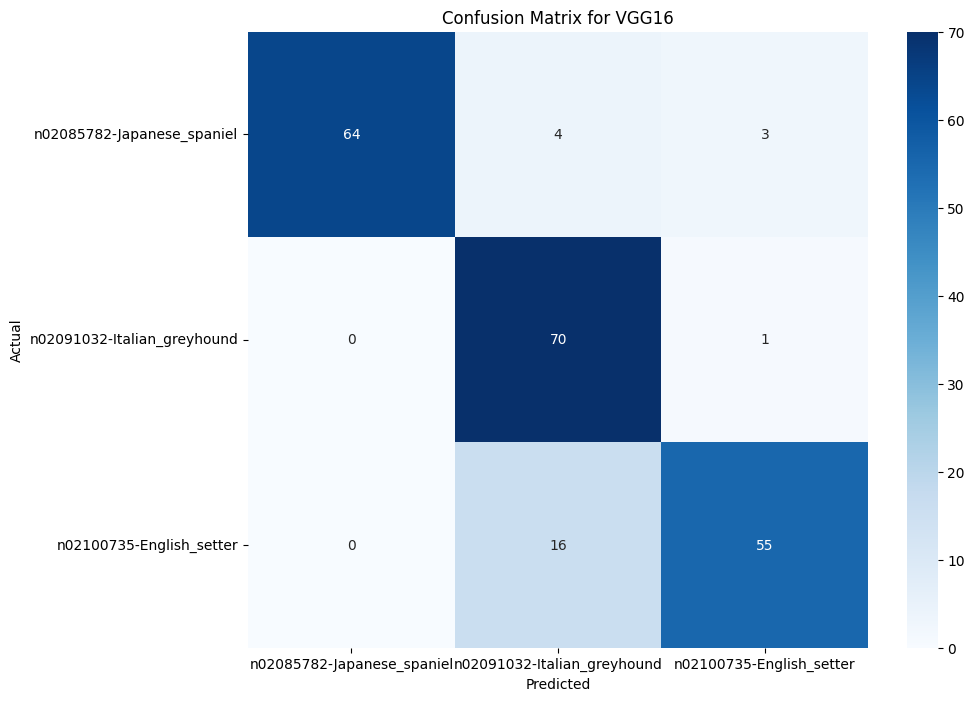

Classification Report for VGG16:
                              precision    recall  f1-score   support

 n02085782-Japanese_spaniel       1.00      0.90      0.95        71
n02091032-Italian_greyhound       0.78      0.99      0.87        71
   n02100735-English_setter       0.93      0.77      0.85        71

                   accuracy                           0.89       213
                  macro avg       0.90      0.89      0.89       213
               weighted avg       0.90      0.89      0.89       213

Évaluation du modèle ResNet50...
7/7 [==============================] - 16s 2s/step
7/7 - 15s - loss: 0.9461 - accuracy: 0.5070 - 15s/epoch - 2s/step
Précision sur les données de test : 50.70%


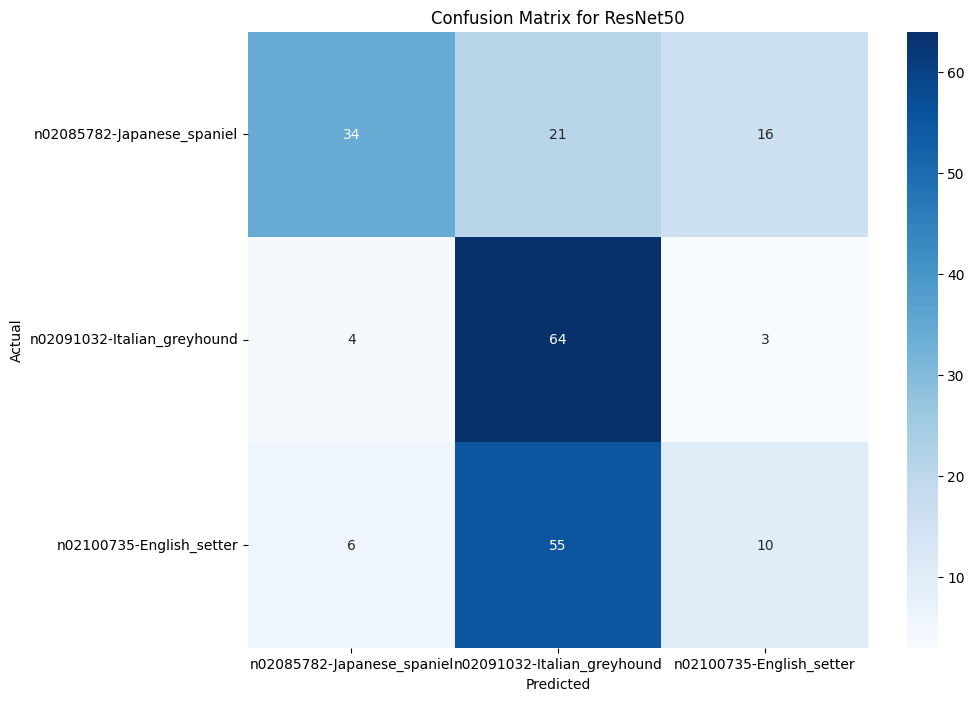

Classification Report for ResNet50:
                              precision    recall  f1-score   support

 n02085782-Japanese_spaniel       0.77      0.48      0.59        71
n02091032-Italian_greyhound       0.46      0.90      0.61        71
   n02100735-English_setter       0.34      0.14      0.20        71

                   accuracy                           0.51       213
                  macro avg       0.52      0.51      0.47       213
               weighted avg       0.52      0.51      0.47       213

Évaluation du modèle InceptionV3...
7/7 [==============================] - 10s 1s/step
7/7 - 6s - loss: 0.1309 - accuracy: 0.9531 - 6s/epoch - 898ms/step
Précision sur les données de test : 95.31%


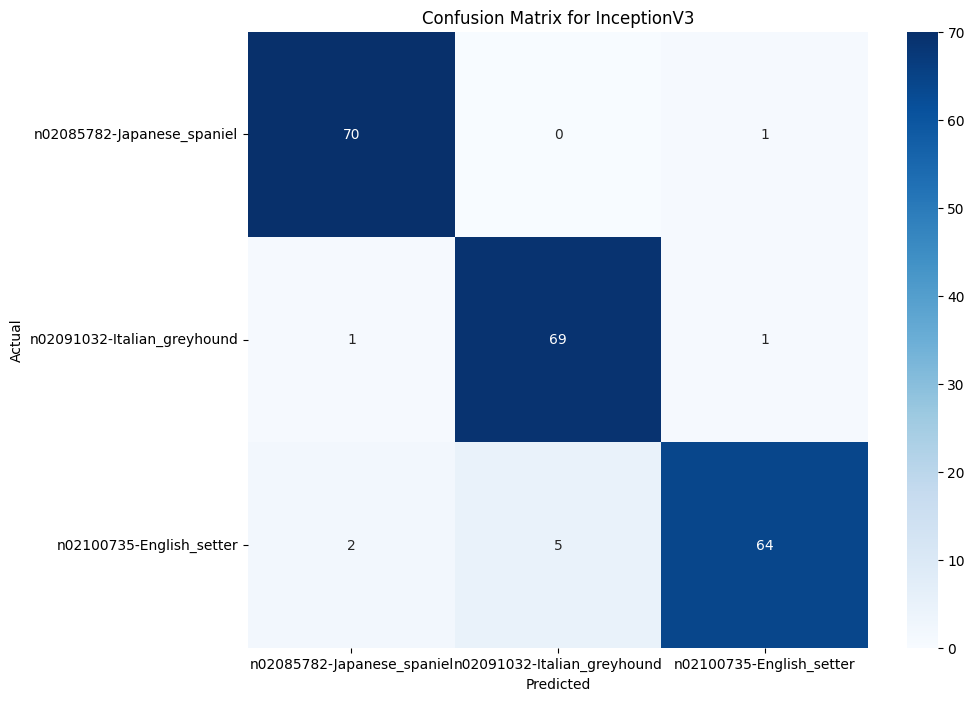

Classification Report for InceptionV3:
                              precision    recall  f1-score   support

 n02085782-Japanese_spaniel       0.96      0.99      0.97        71
n02091032-Italian_greyhound       0.93      0.97      0.95        71
   n02100735-English_setter       0.97      0.90      0.93        71

                   accuracy                           0.95       213
                  macro avg       0.95      0.95      0.95       213
               weighted avg       0.95      0.95      0.95       213

Évaluation du modèle InceptionResNetV2...
7/7 [==============================] - 19s 2s/step
7/7 - 15s - loss: 0.0516 - accuracy: 0.9953 - 15s/epoch - 2s/step
Précision sur les données de test : 99.53%


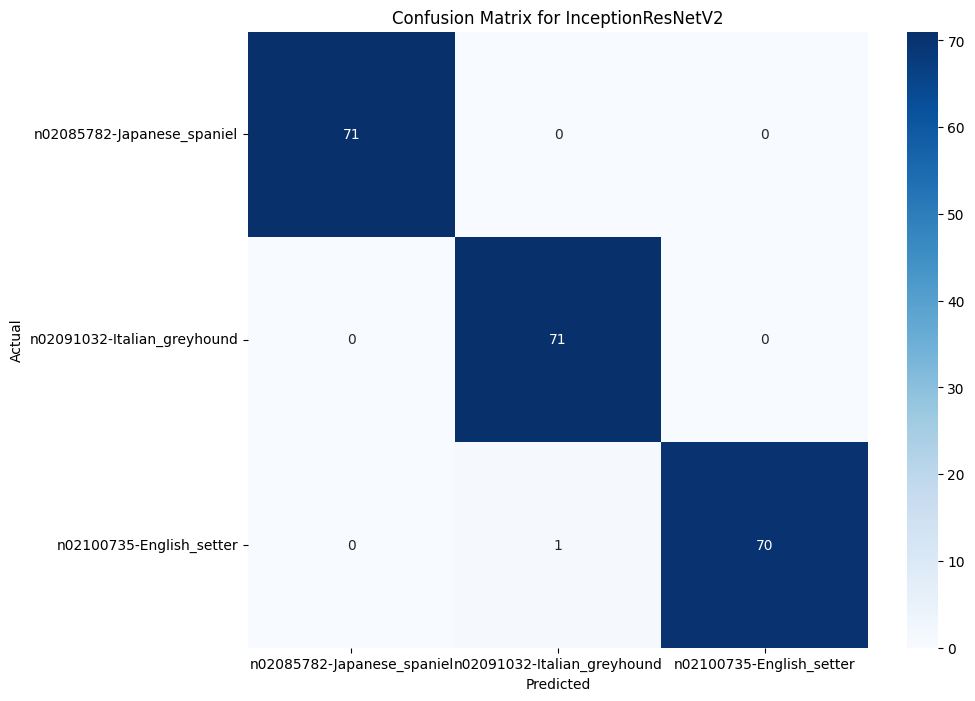

Classification Report for InceptionResNetV2:
                              precision    recall  f1-score   support

 n02085782-Japanese_spaniel       1.00      1.00      1.00        71
n02091032-Italian_greyhound       0.99      1.00      0.99        71
   n02100735-English_setter       1.00      0.99      0.99        71

                   accuracy                           1.00       213
                  macro avg       1.00      1.00      1.00       213
               weighted avg       1.00      1.00      1.00       213



In [21]:
class_names = list(train_generator.class_indices.keys())
evaluation_results = {}

for model_name, model in models.items():
    print(f"Évaluation du modèle {model_name}...")
    cm, report = evaluate_model(model, test_generator, class_names, model_name)
    evaluation_results[model_name] = {'confusion_matrix': cm, 'classification_report': report}


## **Tableau de comparaison des modèles**

In [22]:
# Fonction pour extraire les métriques du rapport de classification
def extract_metrics(report):
    lines = report.split('\n')
    metrics = {}
    for line in lines[2:-3]:
        parts = line.split()
        if len(parts) >= 5:
            class_name = parts[0]
            metrics[class_name] = {
                'precision': float(parts[1]),
                'recall': float(parts[2]),
                'f1-score': float(parts[3])
            }
    return metrics

# Initialiser un dictionnaire pour stocker les résultats
results = {
    'Model': [],
    'Test Accuracy': [],
    'Precision (avg)': [],
    'Recall (avg)': [],
    'F1-Score (avg)': []
}

# Parcourir les résultats de l'évaluation pour chaque modèle
for model_name, metrics in evaluation_results.items():
    # Ajouter le nom du modèle
    results['Model'].append(model_name)

    # Extraire la précision sur le test set à partir du rapport de classification
    lines = metrics['classification_report'].split('\n')
    accuracy_line = lines[-2] if 'accuracy' in lines[-2] else lines[-3]
    test_accuracy = accuracy_line.split()[-2]
    results['Test Accuracy'].append(float(test_accuracy))

    # Extraire les métriques du rapport de classification
    metrics_dict = extract_metrics(metrics['classification_report'])

    # Calculer les moyennes des métriques
    avg_precision = sum([v['precision'] for v in metrics_dict.values()]) / len(metrics_dict)
    avg_recall = sum([v['recall'] for v in metrics_dict.values()]) / len(metrics_dict)
    avg_f1 = sum([v['f1-score'] for v in metrics_dict.values()]) / len(metrics_dict)

    # Ajouter les moyennes au tableau des résultats
    results['Precision (avg)'].append(avg_precision)
    results['Recall (avg)'].append(avg_recall)
    results['F1-Score (avg)'].append(avg_f1)

# Créer un DataFrame à partir du dictionnaire des résultats
df_results = pd.DataFrame(results)

# Afficher le tableau des résultats
print(df_results)

               Model  Test Accuracy  Precision (avg)  Recall (avg)  \
0              VGG16           0.89         0.903333      0.886667   
1           ResNet50           0.47         0.523333      0.506667   
2        InceptionV3           0.95         0.953333      0.953333   
3  InceptionResNetV2           1.00         0.996667      0.996667   

   F1-Score (avg)  
0        0.890000  
1        0.466667  
2        0.950000  
3        0.993333  


## **Sauvegarde du meilleur modèle**

In [23]:
# Charger les meilleurs poids du modèle
best_model = models['InceptionResNetV2']
best_model.load_weights('InceptionResNetV2_best_model.h5')

# Sauvegarder le modèle entier
save_path = '/content/drive/MyDrive/inception_resnet_v2_model.h5'
best_model.save(save_path)
print(f'Modèle sauvegardé à : {save_path}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modèle sauvegardé à : /content/drive/MyDrive/inception_resnet_v2_model.h5
